# Learning the Latent Structure with Diffusion Models

In this notebook, we tackle the problem of learning the latent structure of sparse quark/gluon jet images using diffusion models. We face a challenging task since each image is 125×125 with only a few bright pixels among largely dim regions. Our initial attempts at pixel-space diffusion produced trivial (all-black or all-white) outputs. To address this, we adopt a two-stage approach:

1. **Stage 1: Weighted VAE**  
   We train a Variational Autoencoder (VAE) using a custom weighted reconstruction loss. This loss emphasizes the few bright pixels so that the latent code captures the essential structure. The VAE compresses each 125×125 image (for a given channel) into a lower-dimensional latent representation.

2. **Stage 2: Latent Diffusion**  
   Instead of applying diffusion directly in pixel space, we train a diffusion model in the latent space. A simple MLP diffusion model is trained to predict the noise added to the latent code. At sampling time, we generate latent codes using the reverse diffusion process and decode them via the VAE decoder.

---

## Observations and Challenges

- **Sparse and Dim Images:**  
  Most pixels in the jet images are near zero, with only a few bright pixels. A standard loss (e.g., MSE) tends to encourage trivial solutions. To counteract this, we devised a weighted loss that increases the penalty on errors for pixels above a small threshold.

- **Initial Diffusion Results:**  
  Our early attempts at pixel-space diffusion produced outputs that were either entirely black or overly saturated. Shifting to a latent-space approach allowed us to work with a more compressed and denser representation.

- **Model Tuning:**  
  We experimented with loss weighting, threshold values, and the beta schedule. We also compared the baseline VAE reconstruction with the latent diffusion reconstructions using MSE and visual inspection.

In [1]:
import os
import math
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


class ChannelDataset(Dataset):
    def __init__(self, hdf5_file, channel_index):
        with h5py.File(hdf5_file, 'r') as f:
            X_jets = f['X_jets'][0:40000]  # shape: (N,125,125,3)
        channel_data = X_jets[..., channel_index]  # shape: (N,125,125)
        normalized_data = []
        for img in channel_data:
            min_val = img.min()
            max_val = img.max()
            norm_img = (img - min_val) / (max_val - min_val + 1e-8)
            normalized_data.append(norm_img)
        self.data = torch.tensor(np.array(normalized_data, dtype=np.float32)).unsqueeze(1)  # (N,1,125,125)

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx]

In [2]:
class WeightedVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(WeightedVAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder: a few convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 125->63
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),   # 63->32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 32->16
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(128 * 16 * 16, latent_dim)
        
        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 128 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16->32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 32->64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # 64->128
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)  # (B,128,16,16)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 16, 16)
        x = self.decoder(x)
        # Crop to 125x125
        return x[..., :125, :125]
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Custom weighted reconstruction loss for the VAE.
def weighted_vae_loss(recon, x, mu, logvar, threshold=0.05, high_weight=10.0, low_weight=2.0):
    weight = torch.where(x > threshold, high_weight, low_weight)
    recon_loss = (weight * (recon - x) ** 2).mean() / weight.mean()
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [3]:
class LatentDiffusionModel(nn.Module):
    def __init__(self, latent_dim=64):
        super(LatentDiffusionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
    def forward(self, z, t):
        # For simplicity, we are not explicitly conditioning on t here,
        # but we could also add t-conditioning (e.g., via a time embedding) if desired.
        return self.model(z)

def latent_linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

latent_timesteps = 1000
betas_latent = latent_linear_beta_schedule(latent_timesteps)
alphas_latent = 1.0 - betas_latent
alpha_bars_latent = torch.cumprod(alphas_latent, dim=0)

def forward_diffusion_latent(z0, t, device):
    alpha_bars_device = alpha_bars_latent.to(device)
    sqrt_alpha_bar = torch.sqrt(alpha_bars_device[t.cpu()]).view(-1, 1)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars_device[t.cpu()]).view(-1, 1)
    noise = torch.randn_like(z0).to(device)
    z_t = sqrt_alpha_bar * z0 + sqrt_one_minus_alpha_bar * noise
    return z_t, noise

In [4]:
def train_vae(model, dataloader, num_epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in dataloader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)
            loss = weighted_vae_loss(recon, batch, mu, logvar, threshold=0.1, high_weight=50.0, low_weight=2.0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.size(0)
        avg_loss = total_loss / len(dataloader.dataset)
        print(f"VAE Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")
    return model

def train_latent_diffusion(model, encoder, dataloader, num_epochs, device, timesteps=1000):
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    mse_loss = nn.MSELoss()
    model.train()
    encoder.eval() 
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in dataloader:
            batch = batch.to(device)
            with torch.no_grad():
                mu, logvar = encoder.encode(batch)
                z0 = encoder.reparameterize(mu, logvar)
            B = z0.size(0)
            t = torch.randint(0, timesteps, (B,), device=device)
            z_t, noise = forward_diffusion_latent(z0, t, device)
            pred_noise = model(z_t, t)
            loss = mse_loss(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * B
        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Latent Diffusion Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")
    return model

@torch.no_grad()
def sample_latent_diffusion(model, decoder, device, latent_dim=64, timesteps=1000):
    model.eval()
    # Start from random noise in latent space.
    z = torch.randn(1, latent_dim).to(device)
    for t in reversed(range(timesteps)):
        t_tensor = torch.tensor([t], device=device)
        pred_noise = model(z, t_tensor)
        alpha = alphas_latent[t].to(device)
        alpha_bar = alpha_bars_latent[t].to(device)
        beta = betas_latent[t].to(device)
        z = (1 / math.sqrt(alpha)) * (z - ((1 - alpha) / math.sqrt(1 - alpha_bar)) * pred_noise)
        if t > 0:
            z = z + math.sqrt(beta) * torch.randn_like(z).to(device)
    # Decode the latent code into an image.
    reconstructed = decoder(z)
    return reconstructed

def compute_mse(img1, img2):
    return ((img1 - img2)**2).mean().item()

hdf5_file = '/kaggle/input/quark-gluon-lhc/quark-gluon_data-set_n139306.hdf5'
channel_names = {0: 'ECAL', 1: 'HCAL', 2: 'Tracks'}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters, we can tune them later
vae_epochs = 20   
diffusion_epochs = 50
batch_size = 128
latent_dim = 64


Processing channel: ECAL
Training Weighted VAE...
VAE Epoch 1/20, Loss: 0.249767
VAE Epoch 2/20, Loss: 0.178660
VAE Epoch 3/20, Loss: 0.097755
VAE Epoch 4/20, Loss: 0.044680
VAE Epoch 5/20, Loss: 0.026245
VAE Epoch 6/20, Loss: 0.019027
VAE Epoch 7/20, Loss: 0.013802
VAE Epoch 8/20, Loss: 0.009986
VAE Epoch 9/20, Loss: 0.007663
VAE Epoch 10/20, Loss: 0.006325
VAE Epoch 11/20, Loss: 0.005518
VAE Epoch 12/20, Loss: 0.004997
VAE Epoch 13/20, Loss: 0.004592
VAE Epoch 14/20, Loss: 0.004265
VAE Epoch 15/20, Loss: 0.003974
VAE Epoch 16/20, Loss: 0.003726
VAE Epoch 17/20, Loss: 0.003514
VAE Epoch 18/20, Loss: 0.003339
VAE Epoch 19/20, Loss: 0.003196
VAE Epoch 20/20, Loss: 0.003081
ECAL VAE Reconstruction MSE: 0.000541
Training Latent Diffusion Model...
Latent Diffusion Epoch 1/50, Loss: 1.012021
Latent Diffusion Epoch 2/50, Loss: 0.997332
Latent Diffusion Epoch 3/50, Loss: 0.988597
Latent Diffusion Epoch 4/50, Loss: 0.976030
Latent Diffusion Epoch 5/50, Loss: 0.965127
Latent Diffusion Epoch 6/

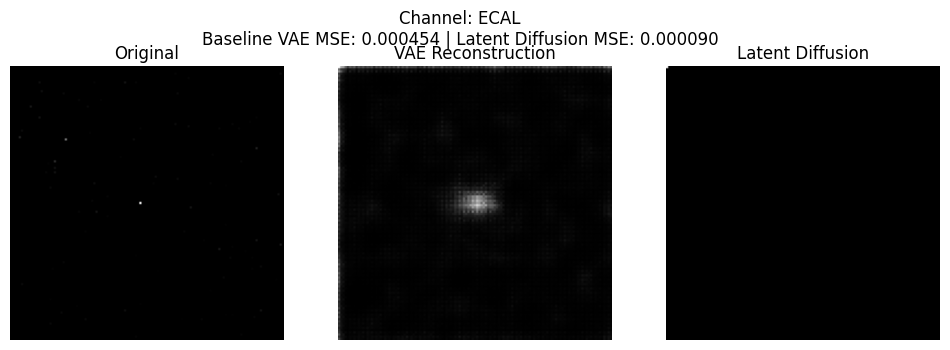


Processing channel: HCAL
Training Weighted VAE...
VAE Epoch 1/20, Loss: 0.276976
VAE Epoch 2/20, Loss: 0.223746
VAE Epoch 3/20, Loss: 0.150191
VAE Epoch 4/20, Loss: 0.065614
VAE Epoch 5/20, Loss: 0.039108
VAE Epoch 6/20, Loss: 0.031861
VAE Epoch 7/20, Loss: 0.027419
VAE Epoch 8/20, Loss: 0.023621
VAE Epoch 9/20, Loss: 0.019729
VAE Epoch 10/20, Loss: 0.015778
VAE Epoch 11/20, Loss: 0.011845
VAE Epoch 12/20, Loss: 0.008660
VAE Epoch 13/20, Loss: 0.006770
VAE Epoch 14/20, Loss: 0.005656
VAE Epoch 15/20, Loss: 0.004984
VAE Epoch 16/20, Loss: 0.004522
VAE Epoch 17/20, Loss: 0.004179
VAE Epoch 18/20, Loss: 0.003895
VAE Epoch 19/20, Loss: 0.003677
VAE Epoch 20/20, Loss: 0.003522
HCAL VAE Reconstruction MSE: 0.000733
Training Latent Diffusion Model...
Latent Diffusion Epoch 1/50, Loss: 1.003596
Latent Diffusion Epoch 2/50, Loss: 0.992982
Latent Diffusion Epoch 3/50, Loss: 0.982948
Latent Diffusion Epoch 4/50, Loss: 0.970904
Latent Diffusion Epoch 5/50, Loss: 0.957013
Latent Diffusion Epoch 6/

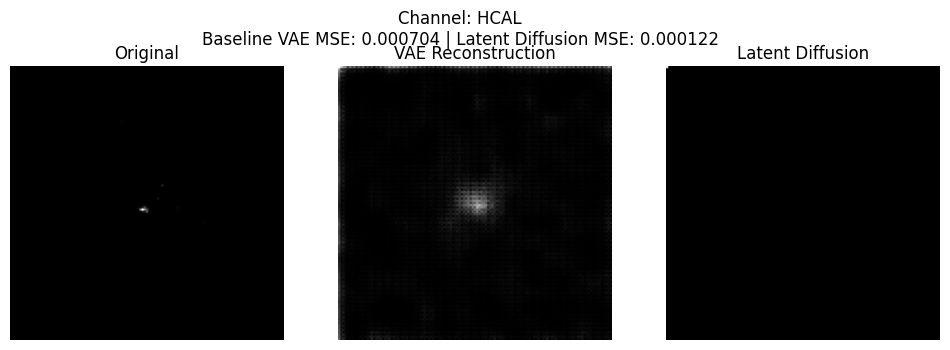


Processing channel: Tracks
Training Weighted VAE...
VAE Epoch 1/20, Loss: 0.160213
VAE Epoch 2/20, Loss: 0.120873
VAE Epoch 3/20, Loss: 0.081348
VAE Epoch 4/20, Loss: 0.056872
VAE Epoch 5/20, Loss: 0.045192
VAE Epoch 6/20, Loss: 0.039430
VAE Epoch 7/20, Loss: 0.036094
VAE Epoch 8/20, Loss: 0.034026
VAE Epoch 9/20, Loss: 0.032726
VAE Epoch 10/20, Loss: 0.031935
VAE Epoch 11/20, Loss: 0.031373
VAE Epoch 12/20, Loss: 0.030943
VAE Epoch 13/20, Loss: 0.030566
VAE Epoch 14/20, Loss: 0.030217
VAE Epoch 15/20, Loss: 0.029831
VAE Epoch 16/20, Loss: 0.029394
VAE Epoch 17/20, Loss: 0.028874
VAE Epoch 18/20, Loss: 0.028259
VAE Epoch 19/20, Loss: 0.027506
VAE Epoch 20/20, Loss: 0.026643
Tracks VAE Reconstruction MSE: 0.005572
Training Latent Diffusion Model...
Latent Diffusion Epoch 1/50, Loss: 1.006399
Latent Diffusion Epoch 2/50, Loss: 0.994938
Latent Diffusion Epoch 3/50, Loss: 0.985664
Latent Diffusion Epoch 4/50, Loss: 0.971738
Latent Diffusion Epoch 5/50, Loss: 0.956903
Latent Diffusion Epoc

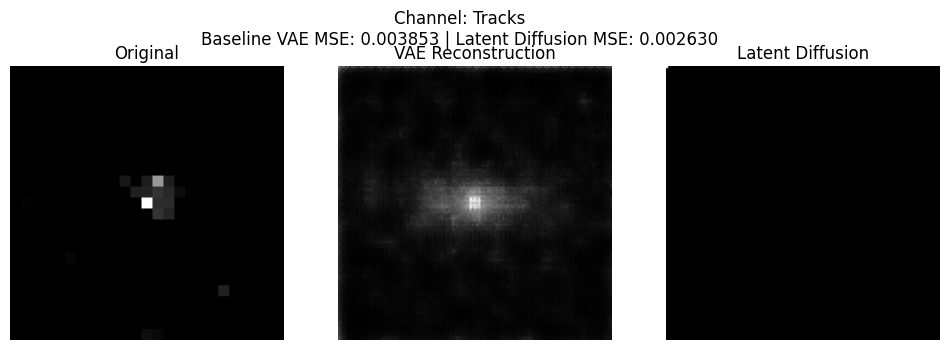

In [5]:
for channel_idx, channel_name in channel_names.items():
    print(f"\nProcessing channel: {channel_name}")
    dataset = ChannelDataset(hdf5_file, channel_idx)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    vae_model = WeightedVAE(latent_dim=latent_dim).to(device)
    print("Training Weighted VAE...")
    vae_model = train_vae(vae_model, dataloader, vae_epochs, device)
    
    sample = next(iter(dataloader)).to(device)
    recon_sample, _, _ = vae_model(sample)
    vae_mse = compute_mse(sample, recon_sample)
    print(f"{channel_name} VAE Reconstruction MSE: {vae_mse:.6f}")
    
    latent_diffusion_model = LatentDiffusionModel(latent_dim=latent_dim).to(device)
    print("Training Latent Diffusion Model...")
    latent_diffusion_model = train_latent_diffusion(latent_diffusion_model, vae_model, dataloader, diffusion_epochs, device, timesteps=latent_timesteps)
    
    reconstructed = sample_latent_diffusion(latent_diffusion_model, vae_model.decode, device, latent_dim=latent_dim, timesteps=latent_timesteps)
    
    original = sample[0:1]
    with torch.no_grad():
        mu, logvar = vae_model.encode(original)
        z0 = vae_model.reparameterize(mu, logvar)
    baseline_recon = vae_model.decode(z0)
    baseline_mse = compute_mse(original, baseline_recon)
    diffusion_mse = compute_mse(original, reconstructed)
    
    print(f"{channel_name} - Baseline VAE MSE: {baseline_mse:.6f}, Latent Diffusion MSE: {diffusion_mse:.6f}")
    
    # Visualize side-by-side comparison: Original, Baseline VAE Reconstruction, and Latent Diffusion Reconstruction.
    original_np = original.squeeze().cpu().detach().numpy()
    baseline_np = baseline_recon.squeeze().cpu().detach().numpy()
    diffusion_np = reconstructed.squeeze().cpu().detach().numpy()

    
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Channel: {channel_name}\nBaseline VAE MSE: {baseline_mse:.6f} | Latent Diffusion MSE: {diffusion_mse:.6f}")
    plt.subplot(1, 3, 1)
    plt.imshow(original_np, cmap='gray')
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(baseline_np, cmap='gray')
    plt.title("VAE Reconstruction")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(diffusion_np, cmap='gray')
    plt.title("Latent Diffusion")
    plt.axis("off")
    
    plt.show()

### Visualizing the results


Visualizing diffusion generations for channel: ECAL


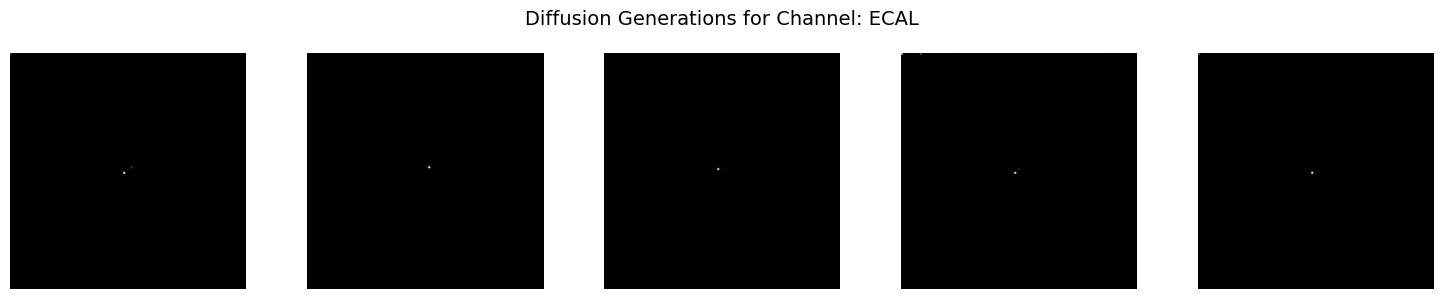


Visualizing diffusion generations for channel: HCAL


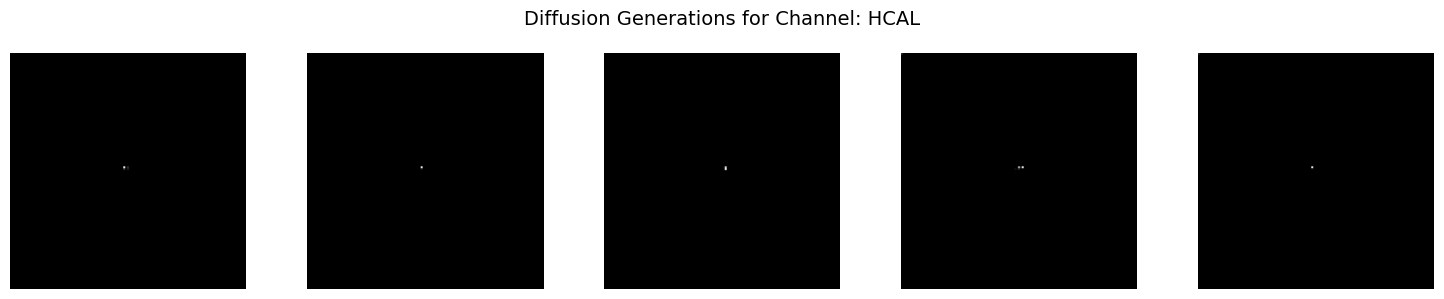


Visualizing diffusion generations for channel: Tracks


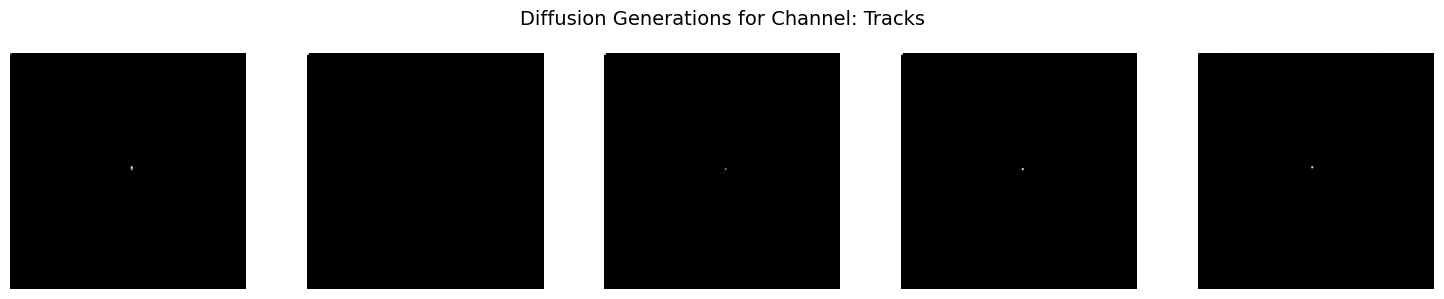

In [8]:
import matplotlib.pyplot as plt

num_samples = 5

for channel_idx, channel_name in channel_names.items():
    print(f"\nVisualizing diffusion generations for channel: {channel_name}")
    samples = []
    for i in range(num_samples):
        sample_img = sample_latent_diffusion(latent_diffusion_model, vae_model.decode, device, latent_dim=latent_dim, timesteps=latent_timesteps)
        sample_np = sample_img.squeeze().cpu().detach().numpy()
        samples.append(sample_np)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
    fig.suptitle(f"Diffusion Generations for Channel: {channel_name}", fontsize=14)
    for ax, img in zip(axes, samples):
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Except for tracks, we get pretty decent results (visually) for the ECAL and HCAL channels.